##**Introduction**


Sentiment Analysis can be defined as the process of analyzing text data and categorizing them into Positive, Negative, or Neutral sentiments. Sentiment Analysis is used in many cases like Social Media Monitoring, Customer service, Brand Monitoring, political campaigns, etc. Analyzing customer feedback such as social media conversations, product reviews, and survey responses allows companies to understand the customer’s emotions better which is becoming more essential to meet their needs.

Tweet => "My ridiculous dog is amazing." [sentiment: positive]

With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or devastate profit because it strikes a negative tone. **Capturing sentiment in language is important** in these times where decisions and reactions are created and updated in seconds. **But, which words actually lead to the sentiment description?** In this competition you will need to **pick out the part of the tweet (word or phrase) that reflects the sentiment**.



##**Business Problem**


It is almost impossible to manually sort thousands of social media conversations, customer reviews, and surveys. The problem I am trying to solve here is part of this Kaggle competition. In this problem, we are given some text data along with their **sentiment(positive/negative/neutral)** and **we need to find the phrases/words** **that best support the sentiment.**

##**Data Overview** 

The dataset used here is from the **Kaggle competition Tweet Sentiment Extraction**. The dataset used in this competition is from phrases from Figure Eight’s Data for Everyone platform. 

It consists of two data files train.csv and test.csv, where there are 27481 rows in training data and 3534 rows in test data.


List of columns in the dataset

**textID:** unique id for each row of data

**text:** this column contains text data of the tweet.

**sentiment:** the sentiment of the text (positive/negative/neutral)

**selected_text:** phrases /words from the text that best supports the sentiment


##**Performance Metric**


The performance metric used in this problem is the word-level Jaccard score. The Jaccard Score or Jaccard Similarity is one of the statistics used in understanding the similarity between two sets.

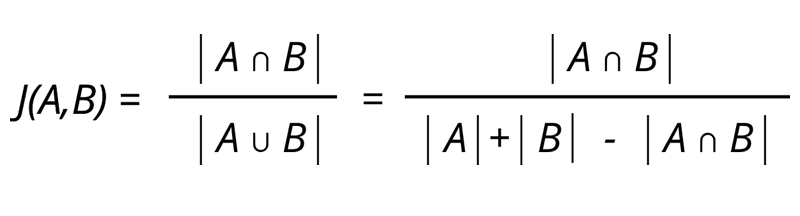



In [ ]:
def jaccard(str1, str2): 
  ''' function takes two input strings and outputs jaccard score '''
  a = set(str(str1).lower().split()) 
  b = set(str(str2).lower().split())
  c = a.intersection(b)
  return float(len(c)) / (len(a) + len(b) - len(c))

##**Reading-Data**

In [ ]:
from google.colab import files
from datetime import datetime                  # using kaggle api token 
api_token = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c 'tweet-sentiment-extraction'

  0% 0.00/307k [00:00<?, ?B/s]
100% 307k/307k [00:00<00:00, 46.6MB/s]
  0% 0.00/41.4k [00:00<?, ?B/s]
100% 41.4k/41.4k [00:00<00:00, 42.7MB/s]
  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 83.4MB/s]


In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
!pip install fuzzywuzzy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np                                                                   # imports ....
import tensorflow as tf
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%load_ext tensorboard
import nltk
from nltk.corpus import stopwords
import string
from tqdm import tqdm
import os
import re
import spacy
import random
import warnings
warnings.filterwarnings("ignore")
from numpy import array
from numpy import asarray
from numpy import zeros
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger,EarlyStopping,ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D,Embedding,LSTM,Embedding,Input,Softmax,Dense,Activation,Dropout
from fuzzywuzzy import fuzz
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import time 
from time import time
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv') 

In [ ]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


##**EDA**

In [ ]:
results_jaccard=[]

for ind,row in train_df.iterrows():
    sentence1 = row.text                                                                  # jaccard score between text and selected text of train data
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [ ]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])               # jaccard score between text and selected text 
train_df = train_df.merge(jaccard,how='outer')
train_df['Num_words_ST'] = train_df['selected_text'].apply(lambda x:len(str(x).split()))               # Number Of words in Selected Text
train_df['Num_word_text'] = train_df['text'].apply(lambda x:len(str(x).split()))                       # Number Of words in main text
train_df['difference_in_words'] = train_df['Num_word_text'] - train_df['Num_words_ST']                 # difference in number of words

In [ ]:
train_df.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


In [ ]:
test_df['Num_word_text'] = test_df['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text


###**Distributions**

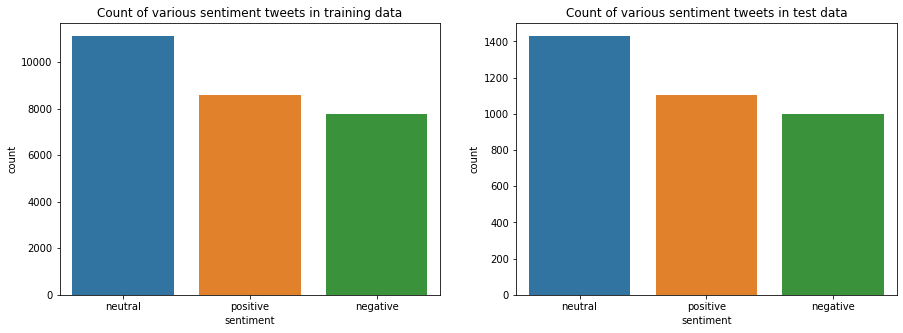

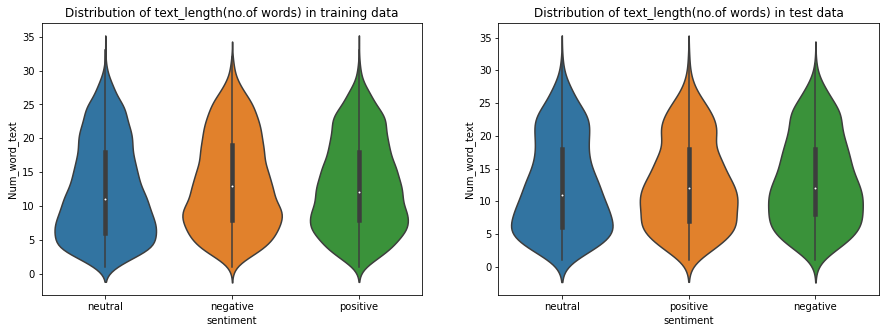

In [ ]:
f, axes = plt.subplots(1, 2,figsize=(15,5))

sns.countplot(x='sentiment',data=train_df,order=train_df.sentiment.value_counts().index,ax=axes[0])\
.set_title('Count of various sentiment tweets in training data');

sns.countplot(x='sentiment',data=test_df,order=test_df.sentiment.value_counts().index,ax=axes[1]);
plt.title('Count of various sentiment tweets in test data');


f, axes = plt.subplots(1, 2,figsize=(15,5))

sns.violinplot(y=train_df.Num_word_text,x=train_df.sentiment,ax=axes[0])\
.set_title('Distribution of text_length(no.of words) in training data');
sns.violinplot(data=test_df,y=test_df.Num_word_text,x='sentiment',ax=axes[1])\
.set_title('Distribution of text_length(no.of words) in test data');

distributions of train and test texts of each sentiment

observations: train and test textdata have same distributions and lenght of text for all sentiments lies between 5 to 10 words 

conclusion: train and test having similar distributions 

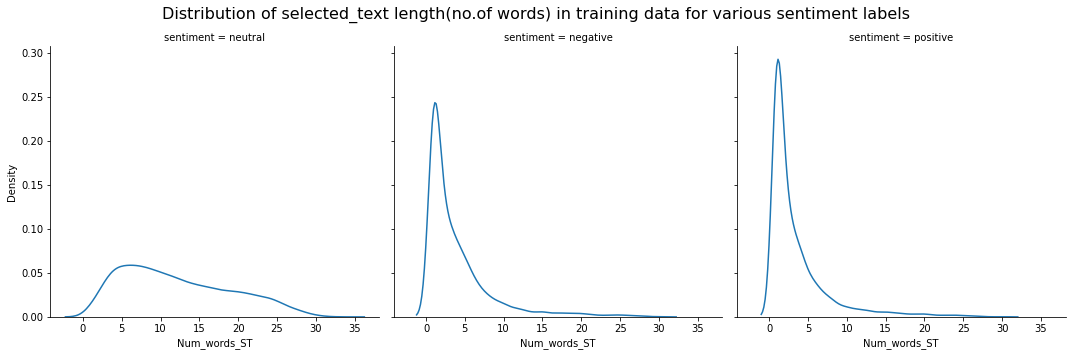

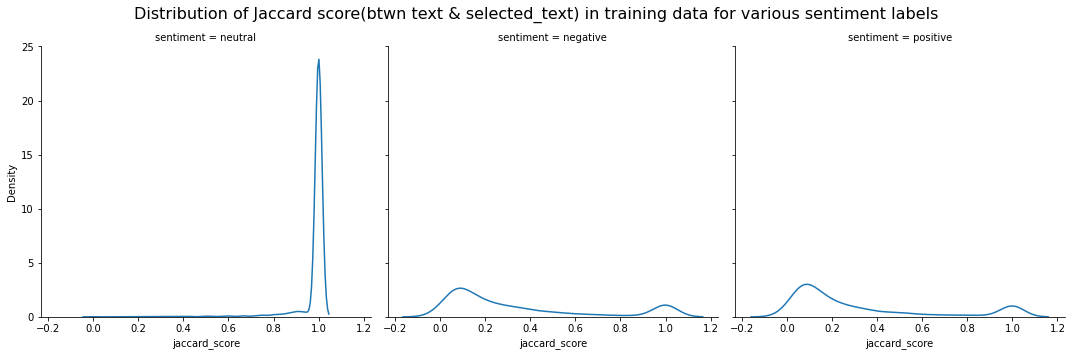

In [ ]:
#https://stackoverflow.com/questions/29813694/how-to-add-a-title-to-seaborn-facet-plot
g=sns.FacetGrid(data=train_df,col='sentiment',height=5);
g.map(sns.kdeplot,'Num_words_ST');
plt.subplots_adjust(top=0.87,)
g.fig.suptitle('Distribution of selected_text length(no.of words) in training data for various sentiment labels',fontsize=16);


g=sns.FacetGrid(data=train_df,col='sentiment',height=5);
g.map(sns.kdeplot,'jaccard_score');
plt.subplots_adjust(top=0.87,)
g.fig.suptitle('Distribution of Jaccard score(btwn text & selected_text) in training data for various sentiment labels',fontsize=16);

text_words and jaccord score distribution plots 

observations:distributions of trian text and test text are very much similar unlike neutral text. jaccard score of negative and positive texts are similar having two peaks. jaccard score of neutral texts are mostly having values 1

conclusion: positive and negative texts are similar with some kurtosis



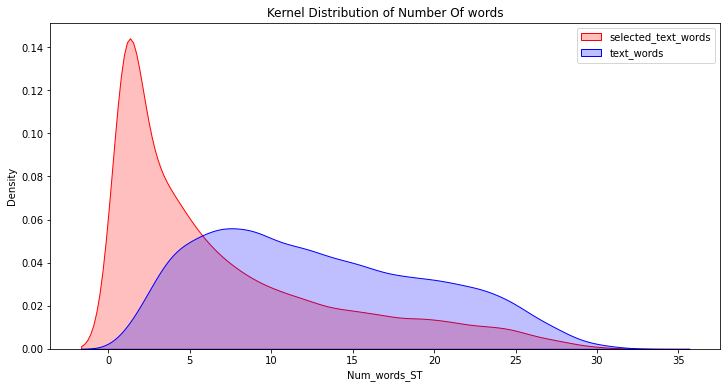

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train_df['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train_df['Num_word_text'], shade=True, color="b")
plt.legend(labels=['selected_text_words','text_words'])


kde plot of text and selected text

observations: number of selected text words are mostley lies between 1 to 10 words.

conclusion: objective is to pick crucial part which supports sentiment thats why small number of words picked from whole text

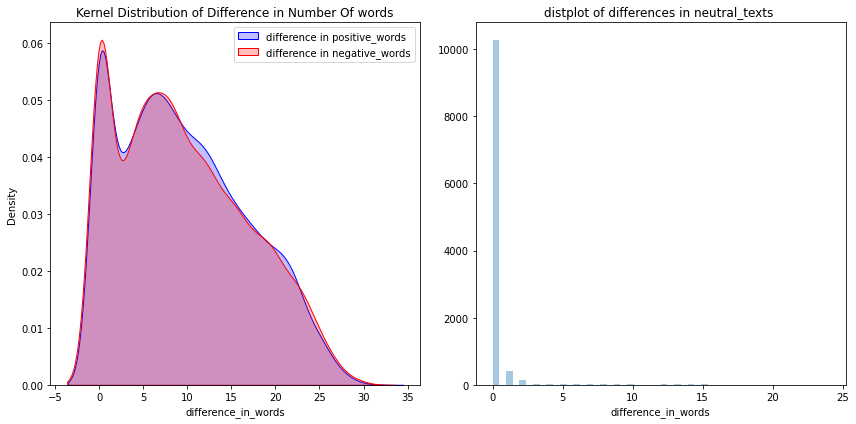

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
p1=sns.kdeplot(train_df[train_df['sentiment']=='positive']['difference_in_words'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train_df[train_df['sentiment']=='negative']['difference_in_words'], shade=True, color="r")
plt.legend(labels=['difference in positive_words','difference in negative_words']) 

plt.subplot(1,2,2)
sns.distplot(train_df[train_df['sentiment']=='neutral']['difference_in_words'],kde=False).set_title('distplot of differences in neutral_texts ')

plt.tight_layout()
plt.show();

distributions of text with different sentiments

observations: positive and negative sentiments distributions are overlaped very well. neutral sentiment having mostly zero difference between text and selected-text

conclusion: for neutral texts most likely to select whole text as sentiment extraction

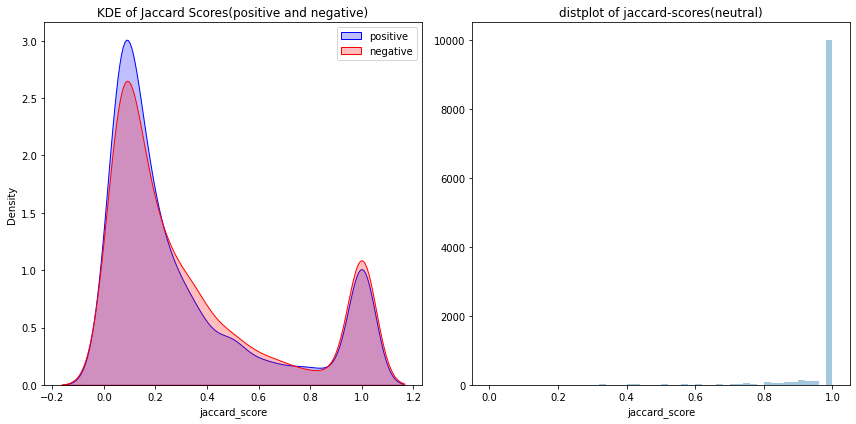

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
p1=sns.kdeplot(train_df[train_df['sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('KDE of Jaccard Scores(positive and negative)')
p2=sns.kdeplot(train_df[train_df['sentiment']=='negative']['jaccard_score'], shade=True, color="r")
plt.legend(labels=['positive','negative'])


plt.subplot(1,2,2)
sns.distplot(train_df[train_df['sentiment']=='neutral']['jaccard_score'],kde=False).set_title('distplot of jaccard-scores(neutral)')

plt.tight_layout()
plt.show()

kde plots of jaccard scores with respect to positive and negative sentiment 

observations: Positive and negative tweets have high kurtosis and thus values are concentrated in two regions narrow and high density
Neutral tweets have a low kurtosis value and their is bump in density near values of 1

###**text-cleaning**

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
# train_df['temp_list'] = train_df['temp_list'].apply(lambda x:remove_stopword(x))

In [ ]:
train_df['text'] = train_df['text'].apply(lambda x:clean_text(x))
train_df['selected_text'] = train_df['selected_text'].apply(lambda x:clean_text(x))

In [ ]:
train_df['temp_list1'] = train_df['text'].apply(lambda x:str(x).split()) #List of words in every row for text
train_df['temp_list1'] = train_df['temp_list1'].apply(lambda x:remove_stopword(x))

###**most-common_words**

In [ ]:
top = Counter([item for sublist in train_df['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,going,1096
10,today,1096


In [ ]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h',width=700, height=700,color='Common_words')
fig.show()

###**Most common words Sentiments Wise**

In [ ]:
Positive_sent = train_df[train_df['sentiment']=='positive']
Negative_sent = train_df[train_df['sentiment']=='negative']
Neutral_sent = train_df[train_df['sentiment']=='neutral']

In [ ]:
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,i,1040
1,good,826
2,happy,730
3,love,697
4,you,623
5,to,608
6,a,589
7,the,571
8,day,456
9,thanks,439


In [ ]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h',width=700, height=700,color='Common_words')
fig.show()

In [ ]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

,Common_words,count
1,to,4103
2,the,3472
3,a,2477
4,my,1971
5,and,1800
6,you,1760
7,in,1574
8,it,1476
9,is,1470
10,for,1406


In [ ]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h',width=700, height=700,color='Common_words')
fig.show()

In [ ]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,to,594
2,the,547
3,my,524
4,a,472
5,im,452
6,not,407
7,is,373
8,so,360
9,miss,358
10,sad,343


In [ ]:
fig = px.bar(temp_negative, x="count", y="Common_words", title='Most Commmon Negative Words', orientation='h',width=700, height=700,color='Common_words') 
fig.show()

###**Word-Clouds of sentiments**

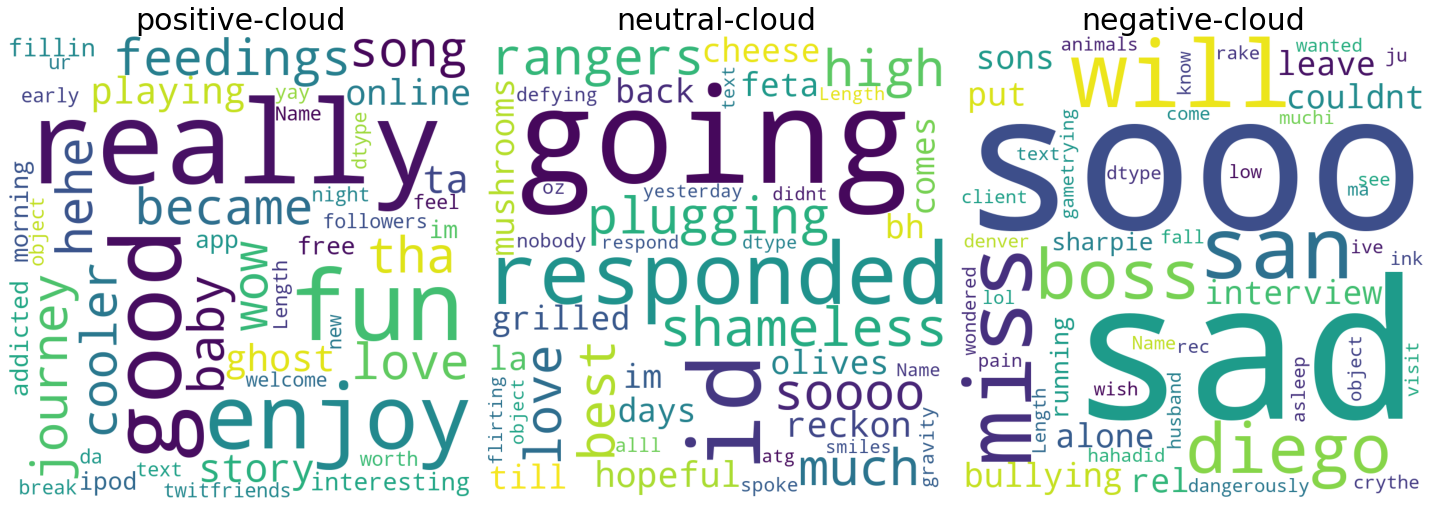

In [ ]:
from wordcloud import WordCloud, STOPWORDS

wordcloud1 = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,min_font_size = 10).generate(str(Positive_sent.text))
wordcloud2 = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,min_font_size = 10).generate(str(Neutral_sent.text))
wordcloud3 = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,min_font_size = 10).generate(str(Negative_sent.text))

plt.figure(figsize = (20, 10), facecolor = None)
plt.subplot(1,3,1)
plt.imshow(wordcloud1)
plt.axis("off")
plt.title('positive-cloud',size=30)

plt.subplot(1,3,2)
plt.imshow(wordcloud2)
plt.axis("off")
plt.title('neutral-cloud',size=30)

plt.subplot(1,3,3)
plt.imshow(wordcloud3) 
plt.axis("off")
plt.tight_layout()
plt.title('negative-cloud',size=30)

plt.show()


##**Pre-Processing**

###**text-cleaning**

In [ ]:
# nltk.download('stopwords')
# !pip install fuzzywuzzy

In [ ]:
#https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
#https://stackoverflow.com/questions/12851791/removing-numbers-from-string
#https://stackoverflow.com/questions/18082130/python-regex-to-remove-all-words-which-contains-number
#https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/

def text_cleaning(text):
  '''' takes input as raw  text  and removes hyperlinks,Numbers,Angular Brackets,Square Brackets,'\n' character,**** by ABUSE,wordpuntuation '''
  text = str(text).lower()
  text = re.sub('https?://\S+|www\.\S+', '', text)  #Removing hyperlinks
  text=re.sub('\S*\d\S*',' ',text) #Removing Numbers
  text=re.sub('<.*?>+',' ',text)   #Removing Angular Brackets
  text=re.sub('\[.*?\]',' ',text)  #Removing Square Brackets
  text=re.sub('\n',' ',text)       #Removing '\n' character 
  text=re.sub('\*+','<ABUSE>',text) #Replacing **** by ABUSE word
  text = "".join([i for i in text if i not in string.punctuation]) # Removing puntuation 

  return text 

train_df['text']=train_df['text'].apply(lambda x:text_cleaning(x))
test_df['text']=test_df['text'].apply(lambda x:text_cleaning(x))
train_df['selected_text']=train_df['selected_text'].apply(lambda x:text_cleaning(x))

In [ ]:
# def remove_stopword(x):
#     return [y for y in x if y not in stopwords.words('english')]
# train_df['selected_text']=train_df['selected_text'].apply(lambda x:remove_stopword(x))
# train_df['text']=train_df['text'].apply(lambda x:remove_stopword(x))

###**text-fixing btw text & selected_text**

In [ ]:
train_df = train_df.drop(train_df[train_df["text"]==' '].index)                # removing empty cells 
train_df = train_df.drop(train_df[train_df["selected_text"]==' '].index)                          


In [ ]:
def miss_match(text,selected):
  ''' function takes text and selected text as input and outputs  miss matched words between them '''
  words=[]
  text=text.split()
  selected=selected.split()
  for i in selected:
    if i not in text:
      words.append(i)
  if len(words)>0:
    return " ".join(words)
  else:
    return '****' 

train_df['spelling']=train_df.apply(lambda x: miss_match(x.text,x.selected_text),axis=1)

In [ ]:
 #https://www.geeksforgeeks.org/python-list-remove/
def remove_spelling(x):
  ''' function takes of df with selected text ,spelling and removes miss matched spelling words from selected text'''
  selected=x[0]
  spelling=x[1]
  selected=selected.split()
  selected.remove(spelling)
  return " ".join(selected)

train_df['selected_text']=train_df[['selected_text','spelling']].apply(lambda x: remove_spelling(x) if len(x['spelling'])==1  else x['selected_text'],axis=1)

**fixing neutral text**

In [ ]:
# finding wrong words(incompleted texts) present between text and selected text 
train_df['spelling']=train_df.apply(lambda x: miss_match(x.text,x.selected_text),axis=1)
# replacing missing selected text in neutral sentiment with text 
train_df['selected_text']=train_df.apply(lambda x: x['text'] if ( (x['spelling']!='****') & (x['sentiment']=='neutral') ) else x['selected_text'],axis=1) 
train_df['spelling']=train_df.apply(lambda x: miss_match(x.text,x.selected_text),axis=1)

**fuzz wuzz fix**

In [ ]:
'''If length of wrong spelling is greater than 1. In that case one can use fuzzy wuzzy library where we can have a score out of 100, that denotes two string are equal by giving similarity index.'''
def fuzz_wuzz(x):
  ''' function takes df of text,selected_text,spelling and replaces selected text words with text words if fuzz_wuzz ratio > 55 '''
  text=x[0]
  selected=x[1]
  spelling=x[2]
  text=text.split()
  selected=selected.split()                      # 1st iteration of fuzz wuzz
  spelling=spelling.split() 
  for s in spelling:
    for t in text:
      if s in selected:                                 # fuzz.ratio > 55( ratio ranges from 1 to 100)
        if(fuzz.ratio(t,s)>55):                            
          index=selected.index(s)
          selected[index]=t
  return " ".join(selected)                          #This ratio uses a simple technique which involves calculating the edit distance (Levenshtein distance) between two strings.


In [ ]:
train_df['selected_text']=train_df[['text','selected_text','spelling']].apply(lambda x: fuzz_wuzz(x) if x['spelling']!='****'  else x['selected_text'],axis=1)
train_df['spelling']=train_df.apply(lambda x: miss_match(x.text,x.selected_text),axis=1)
train_df['selected_text']=train_df[['selected_text','spelling']].apply(lambda x: remove_spelling(x) if len(x['spelling'])==1  else x['selected_text'],axis=1)
train_df['spelling']=train_df.apply(lambda x: miss_match(x.text,x.selected_text),axis=1)

In [ ]:
def fuzz_wuzz(x):
  ''' function takes df of text,selected_text,spelling and replaces selected text words with text words if fuzz_wuzz ratio > 35 '''
  text=x[0]
  selected=x[1]
  spelling=x[2]
  text=text.split()                                   # 2nd iteration of fuzz wuzz
  selected=selected.split()
  spelling=spelling.split()
  for s in spelling:
    for t in text:
      if s in selected:
        if(fuzz.ratio(t,s)>35):                        # fuzz.ratio > 35
          index=selected.index(s)
          selected[index]=t
  return " ".join(selected)

In [ ]:
train_df['selected_text']=train_df[['text','selected_text','spelling']].apply(lambda x: fuzz_wuzz(x) if x['spelling']!='****'  else x['selected_text'],axis=1)
train_df['spelling']=train_df.apply(lambda x: miss_match(x.text,x.selected_text),axis=1)

**hand-fixes**

In [ ]:
train_df.loc[(train_df['spelling']!='****') & (train_df['sentiment']=='positive')]         # for  positive sentiment 


,textID,text,selected_text,sentiment,spelling
1588,a7f72a928a,woooooooooo are you coming to nottingham at...,to lovelovelove,positive,lovelovelove
7410,3463ecdfd6,imintheroom imwatchingthehannahmoviewithmomshe...,great,positive,great
10521,f29edbc282,dora the explorer greetings to your niece,enjoy,positive,enjoy


In [ ]:
train_df.loc[(train_df['spelling']!='****') & (train_df['sentiment']=='negative')]         # for negative sentiment

,textID,text,selected_text,sentiment,spelling
2398,983dfecd25,gonna do laundrynever did laundry a hotel bef...,did miss you r,negative,r
6113,2cb67e64b4,these dogs are going to die if somebody doe...,aam these dogs are going to die if somebody do...,negative,aam
9817,3358792fc9,following and followers nice,not nice,negative,not
13637,d83fd6c942,tweeets fgs tweekdeckkk hates me cryyyy,kk hates me cryyyy,negative,kk
14839,b19376c3bd,just got back fromahem boring but had to eat...,was boring but had to eat nonetheless,negative,was
16201,e78c1ad3f5,off to work off at,lammmeeee,negative,lammmeeee
25293,2fdbe40c03,grreverytime he gets a new girlfriendim at the...,im at the bottom of the totem pole,negative,im


In [ ]:
train_df.loc[7410].text='im in the room im watching the hannah movie with mom she said this film very great'
train_df.loc[1588].selected_text='woooooooooo'                                                                           # positive 
train_df.loc[10521].selected_text='greetings'

train_df.loc[2398].selected_text='did miss you'
train_df.loc[6113].selected_text='these dogs are going to die if somebody doesnt save them'
train_df.loc[9817].text='following and followers not nice'
train_df.loc[13637].selected_text='hates me  cryyyy'
train_df.loc[14839].selected_text='boring but had to eat nonetheless'                                                     # negative
train_df.loc[16201].selected_text='off to work'
train_df.loc[25293].selected_text='at the bottom of the totem pole'


In [ ]:
train_df[train_df.selected_text =='']

,textID,text,selected_text,sentiment,spelling
8729,12f21c8f19,star wars is ABUSE boo i wanna do your job h...,,positive,****
26005,0b3fe0ca78,,,neutral,****


In [ ]:
train_df = train_df.drop([8729,26005],axis=0)

##**NLP Models**

**jaccard score as metric**

In [ ]:
def jaccard(str1,str2): 
  a=set(str1.lower().split()) 
  b=set(str2.lower().split())
  c=a.intersection(b)
  return float(len(c)) / (len(a) + len(b) - len(c))

###**LSTM**

**creating target labels**

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def create_targets(df):
  ''' function takes text and selected_text then creates target labels as 1's&0's  by finding offset of text '''

  df['t_text'] = df['text'].apply(lambda x: nltk.tokenize.word_tokenize(str(x)))
  df['t_selected_text'] = df['selected_text'].apply(lambda x: nltk.tokenize.word_tokenize(str(x)))
  def func(row):
    x,y = row['t_text'],row['t_selected_text'][:]
    for offset in range(len(x)):
      d = dict(zip(x[offset:],y))
      #when k = v that means we found the offset
      check = [k==v for k,v in d.items()]                                                 # 1st approch 
      if all(check)== True:
        break 
    return [0]*offset + [1]*len(y) + [0]* (len(x)-offset-len(y)) 
  
  df['targets'] = df.apply(func,axis=1)
  return df
# train_df = create_targets(train_df)
MAX_TARGET_LEN = max(train_df['targets'].apply(len))

train_df['targets'] = train_df['targets'].apply(lambda x :x + [0] * (MAX_TARGET_LEN-len(x)))
targets=np.asarray(train_df['targets'].values.tolist())

#https://stackoverflow.com/questions/10346336/list-of-lists-into-numpy-array
y = np.array([np.array(xi,dtype='float32') for xi in targets]) 
MAX_TARGET_LEN

47

In [ ]:
def start_index(x):
    text=x[0]
    selected=x[1]
    text=text.split()
    selected=selected.split() 
    word=selected[0]
    index=text.index(word)
    return index
def end_index(x):                                                                          # 2nd approch 
    text=x[0]
    selected=x[1]
    start_index=x[2] 
    text=text.split()
    selected= selected.split()
    word=selected[-1]
    try:
        index=text.index(word,start_index)
    except:
        index=text.index(word)
    return index

train_df['start_index']=train_df[['text','selected_text']].apply(lambda x: start_index(x),axis=1)
train_df['end_index']=train_df[['text','selected_text','start_index']].apply(lambda x: end_index(x),axis=1)
train_df=train_df[train_df.start_index <= train_df.end_index]

y=np.zeros((train_df.shape[0],max(text_split)+1))
for i in range(train_df.shape[0]):
  start=train_df['start_index'][i]
  end=train_df['end_index'][i]
  y[i][start:end+1]=1                                                           #$\color{blue}{\text{good}}$  for coloring text 

***train_test split***

In [ ]:
X=train_df[['textID','text','selected_text','sentiment']]
X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.15,random_state=42)

In [ ]:
print("X_train shape ",X_train.shape,"  X_test shape ",X_valid.shape)
print("\ny_train shape ",y_train.shape,"  y_test shape ",y_valid.shape)

X_train shape  (23274, 4)   X_test shape  (4108, 4)

y_train shape  (23274, 33)   y_test shape  (4108, 33)


In [ ]:
y_train=np.expand_dims(y_train,-1)
y_valid=np.expand_dims(y_valid,-1)
y_train.shape,y_valid.shape                                    # expanding dimensions 

((23274, 33, 1), (4108, 33, 1))

In [ ]:
train_text=X_train['text'].values
valid_text=X_valid['text'].values
train_sentiment=X_train['sentiment'].values                       # data to be fitted
valid_sentiment=X_valid['sentiment'].values

**tokenizing**

In [ ]:
token1=Tokenizer(num_words=None)
max_len_text=32

token1.fit_on_texts(list(train_text))
train_text=token1.texts_to_sequences(train_text)
valid_text=token1.texts_to_sequences(valid_text)


#zero pad the sequences
train_text=pad_sequences(train_text,maxlen=max_len_text,padding='post')
valid_text=pad_sequences(valid_text,maxlen=max_len_text,padding='post')

word_index_text=token1.word_index


In [ ]:
token2=Tokenizer(num_words=None)
max_len_sentiment=1

token2.fit_on_texts(list(train_sentiment))
train_sentiment=token2.texts_to_sequences(train_sentiment)
valid_sentiment=token2.texts_to_sequences(valid_sentiment)


#zero pad the sequences
train_sentiment=pad_sequences(train_sentiment,maxlen=max_len_sentiment,padding='post')
valid_sentiment=pad_sequences(valid_sentiment,maxlen=max_len_sentiment,padding='post')

word_index_sentiment=token2.word_index
print(word_index_sentiment)

{'neutral': 1, 'positive': 2, 'negative': 3}


**glove embeddings**

In [ ]:
embeddings_index = {}
with open('/content/drive/MyDrive/miscellaneous/glove.6B.100d.txt') as f:  #pre trained glove vectors of 100 dimensions
  for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
embedding_matrix_text=np.zeros((len(word_index_text) + 1, 300))
for word, i in tqdm(word_index_text.items()):
    embedding_vector=embeddings_index.get(word)                                 # embedding matrix for text data
    if embedding_vector is not None:
        embedding_matrix_text[i]=embedding_vector

100%|██████████| 24048/24048 [00:00<00:00, 223297.06it/s]


In [ ]:
embedding_matrix_sentiment=np.zeros((len(word_index_sentiment) + 1, 300))
for word, i in tqdm(word_index_sentiment.items()):
    embedding_vector=embeddings_index.get(word)                                # embedding matrix for sentiment 
    if embedding_vector is not None:
        embedding_matrix_sentiment[i]=embedding_vector

100%|██████████| 3/3 [00:00<00:00, 11814.94it/s]


**LSTM as base-model**

In [ ]:
max_len_text  = 46             # 46 + 1 = 47 which out size(y)
max_len_sentiment = 1


In [ ]:
 #masking the input values with mask_zero= True
text_input=Input(shape=(max_len_text,),name='text_input')
embd_text=Embedding(len(word_index_text)+1,100,weights=[embedding_matrix_text],input_length=max_len_text,trainable=False,mask_zero=True,name='embedding_text')(text_input) 

 #masking the input values with mask_zero= True
sentiment_input=Input(shape=(max_len_sentiment,),name='sentiment_input')
embd_sentiment=Embedding(len(word_index_sentiment)+1,100,weights=[embedding_matrix_sentiment],input_length=max_len_text,trainable=False,mask_zero=True,name='embedding_sentiment')(sentiment_input)

con=Concatenate(axis=1)([embd_text,embd_sentiment])
lstm=LSTM(64,return_sequences=True,name='LSTM1')(con)                 #lstm


#dense layers with drop outs and batch normalisation
m=Dense(46,activation="relu",kernel_initializer="he_normal")(lstm) 
m=Dropout(0.5)(m)
m=BatchNormalization()(m)
m=Dense(4,activation="relu", kernel_initializer="he_normal")(m)
output=Dense(1,activation='sigmoid',name='output')(m)

model=Model(inputs=[text_input,sentiment_input],outputs=[output])

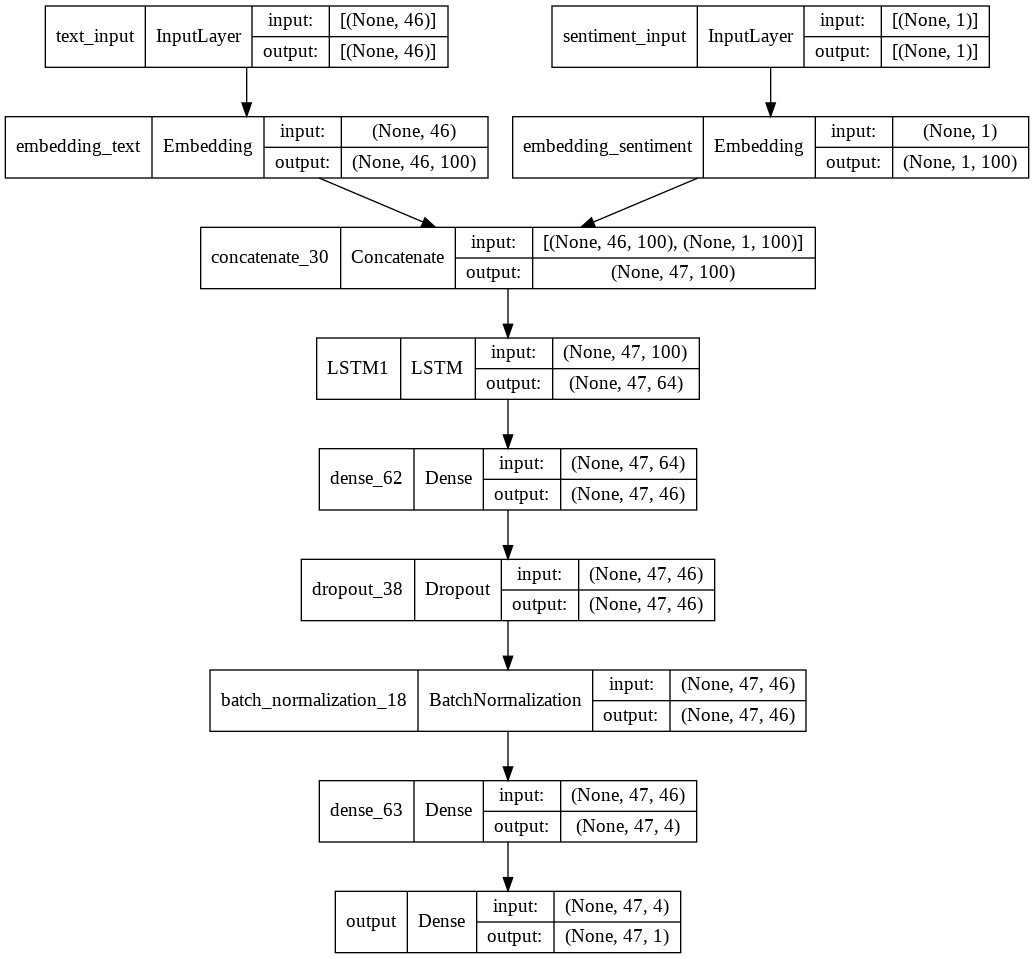

In [ ]:
tf.keras.utils.plot_model(model,'Model.png',show_shapes=True,show_layer_names=True)

In [ ]:
model.summary()

Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 46)]         0           []                               
                                                                                                  
 sentiment_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 embedding_text (Embedding)     (None, 46, 100)      2404900     ['text_input[0][0]']             
                                                                                                  
 embedding_sentiment (Embedding  (None, 1, 100)      400         ['sentiment_input[0][0]']        
 )                                                                                         

In [ ]:
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/base_Lstm_Model/logs/{}'.format(time())) 
early_stop = EarlyStopping(monitor='val_loss', patience=2,verbose=1)                                                                     # call backs 
check_point = ModelCheckpoint('/content/drive/MyDrive/best_lstm.hdf5', monitor='val_loss',save_best_only=True, mode='min') 
call_backs = [early_stop,check_point,tensorboard]

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history=model.fit([train_text,train_sentiment],y_train,epochs=30,batch_size=128,validation_data=([valid_text,valid_sentiment],[y_valid]),verbose=1,callbacks=call_backs) 


Epoch 1/30
182/182 [==============================] - 21s 92ms/step - loss: 0.2018 - accuracy: 0.5518 - val_loss: 0.1885 - val_accuracy: 0.5079
Epoch 2/30
182/182 [==============================] - 16s 89ms/step - loss: 0.1860 - accuracy: 0.5850 - val_loss: 0.1733 - val_accuracy: 0.5909
Epoch 3/30
182/182 [==============================] - 16s 89ms/step - loss: 0.1797 - accuracy: 0.6111 - val_loss: 0.1697 - val_accuracy: 0.6140
Epoch 4/30
182/182 [==============================] - 16s 89ms/step - loss: 0.1782 - accuracy: 0.6208 - val_loss: 0.1689 - val_accuracy: 0.6189
Epoch 5/30
182/182 [==============================] - 16s 86ms/step - loss: 0.1770 - accuracy: 0.6272 - val_loss: 0.1689 - val_accuracy: 0.6188
Epoch 6/30
182/182 [==============================] - 16s 89ms/step - loss: 0.1762 - accuracy: 0.6314 - val_loss: 0.1679 - val_accuracy: 0.6248
Epoch 7/30
182/182 [==============================] - 16s 87ms/step - loss: 0.1757 - accuracy: 0.6337 - val_loss: 0.1674 - val_accuracy:

**train-validation plots**

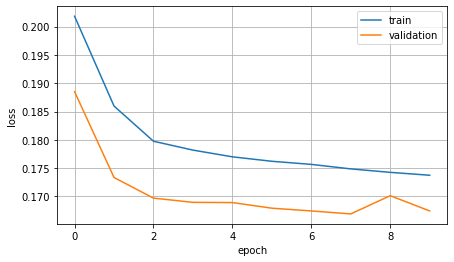

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')                              # loss curve between train and validation data
plt.legend(['train','validation'])
plt.grid()
plt.show()

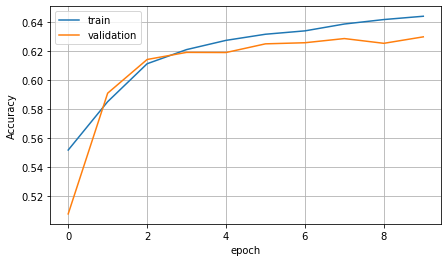

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')                              # metric curve between train and validation data 
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.grid()
plt.show()


**LSTM-predictions**

In [ ]:
valid_pred=model.predict([valid_text,valid_sentiment])       # predicting ...
valid_pred=np.squeeze(valid_pred)
valid_pred=np.round(valid_pred)
valid_pred.shape                                               

(4108, 47)

In [ ]:
pred=[]
for vector in valid_pred:
  index=[]
  for i,value in enumerate(vector):             # convering binary predictions in  1 and 0's  to sequences by taking index values 
    if value == 1:
      index.append(i)
  pred.append(np.array(index))
print(len(pred))

4108


In [ ]:
X_valid['prediction']=pred 


In [ ]:
def index2text(x):
  ''' function takes predicted-sequences and revert backs to the text '''
  pred=[]
  text=x[0]
  index=x[1]                                   # converting sequence index values to text 
  text=text.split()
  l=len(text)
  for i in index:
    if i < l:
      pred.append(text[i])
  return pred


In [ ]:
pred_text=X_valid[['text','prediction']].apply(lambda x:index2text(x),axis=1)
X_valid['pred_text']=pred_text                                                              
X_valid['pred_text']=X_valid['pred_text'].apply(lambda x: ' '.join(x)) 


In [ ]:
X_valid['jaccard']=X_valid.apply(lambda x: jaccard(x.selected_text,x.pred_text),axis=1)
print('Mean training Jaccard score:',np.mean(X_valid['jaccard']))
print("="*150)
print('Mean jaccard score for positive sentiment tweets:',np.mean(X_valid[X_valid['sentiment']=='positive']['jaccard']))
print("="*150)
print('Mean jaccard score for negative sentiment tweets',np.mean(X_valid[X_valid['sentiment']=='negative']['jaccard']))
print("="*150)
print('Mean jaccard score for neutral sentiment tweets',np.mean(X_valid[X_valid['sentiment']=='neutral']['jaccard']))

Mean training Jaccard score: 0.5237762585575317
Mean jaccard score for positive sentiment tweets: 0.37394156270361806
Mean jaccard score for negative sentiment tweets 0.35897511782073316
Mean jaccard score for neutral sentiment tweets 0.7653527807133832


In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir /content/drive/MyDrive/Lstm_Model/logs/

###**DBERT**

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 29.7 MB/s 
     |████████████████████████████████| 596 kB 33.0 MB/s 
     |████████████████████████████████| 61 kB 532 kB/s 
     |████████████████████████████████| 3.3 MB 35.9 MB/s 
     |████████████████████████████████| 895 kB 41.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer,DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',add_prefix_space=True)           # importing DBERT tokenizer for text tokenization

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
x_train, x_val , y_train , y_val = train_test_split(train_df[['text','sentiment']],train_df['selected_text'],test_size=0.2, random_state=42)
x_train.shape, x_val.shape , y_train.shape , y_val.shape

((21976, 2), (5495, 2), (21976,), (5495,))

**DBERT PreP for Train**

In [ ]:
def train_prep(MAX_LEN,tokenizer):
                                                                         # train input_ids and attten_mask  start and end tokens indexes 
  count = x_train.shape[0]
  input_ids = np.zeros((count,MAX_LEN),dtype='int32')
  attention_mask = np.zeros((count,MAX_LEN),dtype='int32')
  start_tokens = np.zeros((count,MAX_LEN),dtype='int32')
  end_tokens = np.zeros((count,MAX_LEN),dtype='int32')
  toks_all = []

  count=0
  for i,each in tqdm(enumerate(x_train.values)):
    val = tokenizer.encode_plus(each[0],each[1],add_special_tokens=True,max_length=MAX_LEN,return_attention_mask=True,pad_to_max_length=True,return_tensors='tf',verbose=False)
    input_ids[i] = val['input_ids']
    attention_mask[i] = val['attention_mask']
    text1 = " "+" ".join(each[0].split())
    text2 = " ".join(y_train.values[i].split())
    
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ':
      chars[idx-1] = 1


    enc = tokenizer.encode(text1) 
    offsets = []; idx=0
    for t in enc:                                                   # adding tuple of start_token and end_token indexs
      w=tokenizer.decode([t])
      offsets.append((idx,idx+len(w)))
      idx += len(w)

    toks = []
    for c,(a,b) in enumerate(offsets):
      sm = np.sum(chars[a:b])
      if sm>0:
        toks.append(c)
    toks_all.append(toks)    
    if len(toks)>0:
      count+=1
      start_tokens[i,(toks[0])+1] = 1                                # if start token 1 else 0
      end_tokens[i,(toks[-1])+1] = 1                                 # if end token 1 else 0

  return toks_all,input_ids,attention_mask,start_tokens,end_tokens



In [ ]:
toks_all,input_ids,attention_mask,start_tokens,end_tokens = train_prep(MAX_LEN=128,tokenizer=tokenizer)      # train ids

**DBERT PreP for Valid**

In [ ]:
def valid_prep(MAX_LEN,tokenizer):
  
  count = y_val.shape[0]
  input_ids_val = np.zeros((count,MAX_LEN),dtype='int32')
  attention_mask_val = np.zeros((count,MAX_LEN),dtype='int32')
  start_tokens_val = np.zeros((count,MAX_LEN),dtype='int32')
  end_tokens_val = np.zeros((count,MAX_LEN),dtype='int32')

  count=0
  for i,each in tqdm(enumerate(x_val.values)):
    val = tokenizer.encode_plus(each[0],each[1],add_special_tokens=True,max_length=MAX_LEN,return_attention_mask=True,pad_to_max_length=True,return_tensors='tf',verbose=False)
    input_ids_val[i] = val['input_ids']
    attention_mask_val[i] = val['attention_mask']
    text1 = " "+" ".join(each[0].split())
    text2 = " ".join(y_val.values[i].split())
    #finding the start index 
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ':
      chars[idx-1] = 1


    enc = tokenizer.encode(text1) 
    offsets = []; idx=0
    for t in enc:
      w=tokenizer.decode([t])
      offsets.append((idx,idx+len(w)))
      idx += len(w)

    toks = []
    for c,(a,b) in enumerate(offsets):
      sm = np.sum(chars[a:b])
      if sm>0:
        toks.append(c)
    toks_all.append(toks)    
    if len(toks)>0:
      count+=1
      start_tokens_val[i,(toks[0])+1] = 1
      end_tokens_val[i,(toks[-1])+1] = 1

  return input_ids_val,attention_mask_val,start_tokens_val,end_tokens_val
 

In [ ]:
input_ids_val,attention_mask_val,start_tokens_val,end_tokens_val = valid_prep(MAX_LEN=128,tokenizer=tokenizer) 

**Model**

In [ ]:
from transformers import TFBertForQuestionAnswering,TFDistilBertForQuestionAnswering
bert= TFDistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased')


Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForQuestionAnswering: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#https://stackoverflow.com/questions/64901831/huggingface-transformer-model-returns-string-instead-of-logits

input1 = Input(shape=(MAX_LEN,),name='input_id',dtype=tf.int32)
input2 = Input(shape=(MAX_LEN,),name='attention_mask',dtype=tf.int32)
start_scores,end_scores = bert(input1,attention_mask = input2).values()
dense1 = Dense(units=MAX_LEN,activation='relu',name='dense1',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(start_scores)
softmax1 = Activation('softmax')(dense1)
dense2 = Dense(units=MAX_LEN,activation='relu',name='dense2',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(end_scores)
softmax2 = Activation('softmax')(dense2)
model = Model(inputs=[input1,input2],outputs=[softmax1,softmax2])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_id (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_for_question_an  TFQuestionAnswering  66364418   ['input_id[0][0]',               
 swering (TFDistilBertForQuesti  ModelOutput(loss=No              'attention_mask[0][0]']         
 onAnswering)                   ne, start_logits=(N                                               
                                one, 128),                                                  

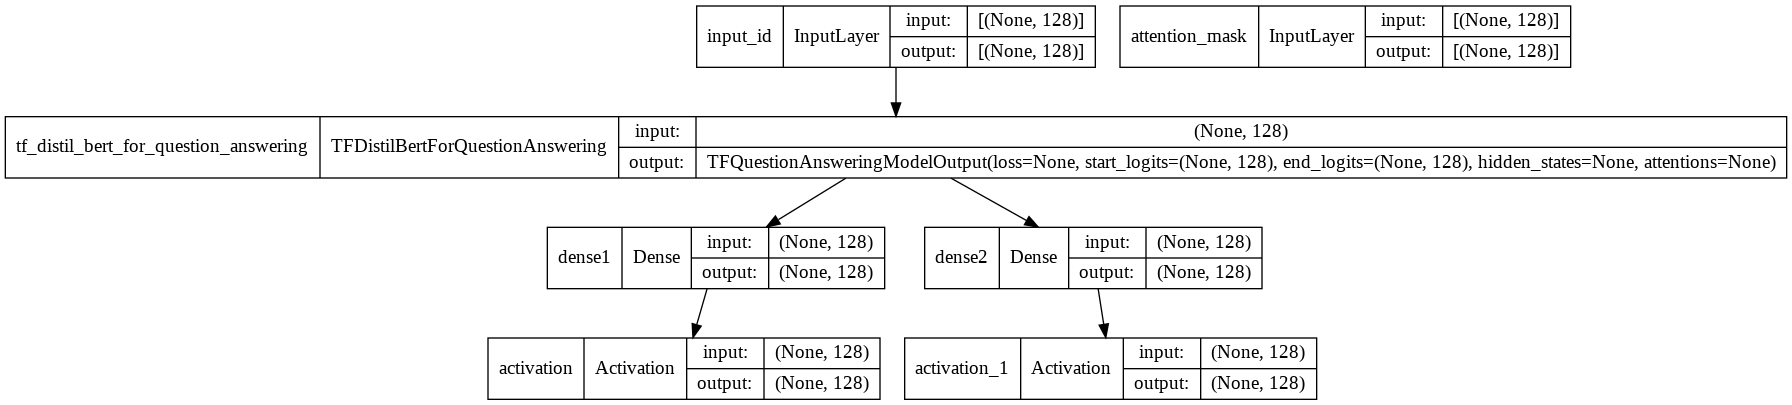

In [ ]:
tf.keras.utils.plot_model(model,'Model.png',show_shapes=True,show_layer_names=True)

In [ ]:
input_data = (input_ids,attention_mask)                                    # train data input
output_data = (start_tokens,end_tokens)                                    # train data ouput

val = (input_ids_val,attention_mask_val)                                   # valid data input
output_val = (start_tokens_val,end_tokens_val)                             # valid data output
val_data = (val,output_val)

In [ ]:
# call backs 

estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/BertQA_logdir',histogram_freq=1, write_graph=True)
checkpoint= tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/BertQA_model.hdf5',save_weights_only=True,monitor='val_loss',save_best_only=True)
callbacks=[tensorboard,checkpoint,estop]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08, clipnorm=1.0)
model.compile(optimizer=opt,loss='categorical_crossentropy')

train_dataset = tf.data.Dataset.from_tensor_slices((input_data, output_data)).shuffle(buffer_size=1024).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(val_data).batch(32)

DBertQA = model.fit(train_dataset,epochs=15,validation_data=val_dataset,callbacks=callbacks)

Epoch 1/15
687/687 [==============================] - 651s 911ms/step - loss: 2.7133 - activation_6_loss: 1.2333 - activation_7_loss: 1.4775 - val_loss: 3.1283 - val_activation_6_loss: 1.5072 - val_activation_7_loss: 1.6186
Epoch 2/15
687/687 [==============================] - 622s 906ms/step - loss: 1.7135 - activation_6_loss: 0.8428 - activation_7_loss: 0.8682 - val_loss: 3.0290 - val_activation_6_loss: 1.4467 - val_activation_7_loss: 1.5798
Epoch 3/15
687/687 [==============================] - 621s 904ms/step - loss: 1.2315 - activation_6_loss: 0.5894 - activation_7_loss: 0.6397 - val_loss: 3.1905 - val_activation_6_loss: 1.5087 - val_activation_7_loss: 1.6793
Epoch 4/15
687/687 [==============================] - 617s 897ms/step - loss: 0.9011 - activation_6_loss: 0.4307 - activation_7_loss: 0.4680 - val_loss: 3.5893 - val_activation_6_loss: 1.6760 - val_activation_7_loss: 1.9108


In [ ]:
MAX_LEN=128                                                                                                            # reload
def create_model():
  input1 = Input(shape=(MAX_LEN,),name='input_id',dtype=tf.int32)
  input2 = Input(shape=(MAX_LEN,),name='attention_mask',dtype=tf.int32)
  start_scores,end_scores = bert(input1,attention_mask = input2).values()
  dense1 = Dense(units=MAX_LEN,activation='relu',name='dense1',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(start_scores)
  softmax1 = Activation('softmax')(dense1)
  dense2 = Dense(units=MAX_LEN,activation='relu',name='dense2',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(end_scores)
  softmax2 = Activation('softmax')(dense2)
  model = Model(inputs=[input1,input2],outputs=[softmax1,softmax2])
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08, clipnorm=1.0)
  model.compile(optimizer=opt,loss='categorical_crossentropy')
  return model

model = create_model()

In [ ]:
model.load_weights('/content/drive/MyDrive/BertQA_model.hdf5')

**Prediction**

In [ ]:
val = (input_ids_val,attention_mask_val)
start_val , end_val = model.predict(val)                                                # valid predictions
start_val.shape,end_val.shape

((5495, 128), (5495, 128))

In [ ]:
pred_values_val=[]
from tqdm import tqdm
for i in tqdm(range(start_val.shape[0])):
  a = np.argmax(start_val[i])
  b = np.argmax(end_val[i])
  text1 = " "+" ".join(x_val['text'].values[i].split())                                 # pred_answer
  enc = tokenizer.encode(text1)
  val = tokenizer.decode(enc[a:b+1])
  pred_values_val.append(val)

100%|██████████| 5495/5495 [00:03<00:00, 1601.33it/s]


In [ ]:

 
for i in range(len(pred_values_val)):
  pred_values_val[i] = pred_values_val[i].replace('[SEP]','')                  # removing [SEP] tokens


In [ ]:
scores_val=[]
x_val['pred_text'] = pred_values_val                                                      # jaccard score calcuation
x_val['selected_text'] = y_val.values
scores=[]
for i in tqdm(range(x_val.shape[0])):
  scores_val.append(jaccard(x_val['pred_text'].values[i],x_val['selected_text'].values[i]))

x_val['jaccard']=scores_val  

100%|██████████| 5495/5495 [00:00<00:00, 47740.44it/s]


In [ ]:
x_val.head(10)

,text,sentiment,pred_text,selected_text,jaccard
7917,this is my update,neutral,this is my update,this is my update,1.000000
15845,whaaat i still have next week,neutral,whaaat i still have next week,whaaat i still have next week,1.000000
21278,happy birthday little sister of mine also go...,positive,happy birthday little sister of mine also good...,happy birthday little sister of mine,0.600000
22338,do some research for my article,neutral,do some research for my article,do some research for my article,1.000000
22474,are you okay,neutral,are you okay,are you okay,1.000000
21560,turned my alarm off this morning because i tho...,negative,turned my alarm off this morning because i tho...,fail,0.043478
8870,elaines my online mommy too she gives good a...,positive,she gives good advice,she gives good advice,1.000000
22030,good ABUSE homie hahahahaha thats what im tal...,positive,good abuse ho,good,0.333333
6693,there are days of summervac school comes alo...,neutral,there are days of summervac school comes along...,the annual problem of r generation is finding ...,0.590909
15718,i have tea have just found a picture of the b...,neutral,i have tea have just found a picture of the bi...,i have tea have just found a picture of the b...,1.000000


In [ ]:
print('Mean Jaccard score for val data:',x_val['jaccard'].values.mean())

Mean Jaccard score for val data: 0.6101828553749852


In [ ]:
print('Mean training Jaccard score:',np.mean(x_val['jaccard']))
print("="*150)
print('Mean jaccard score for positive sentiment tweets:',np.mean(x_val[x_val['sentiment']=='positive']['jaccard']))
print("="*150)
print('Mean jaccard score for negative sentiment tweets',np.mean(x_val[x_val['sentiment']=='negative']['jaccard']))
print("="*150)
print('Mean jaccard score for neutral sentiment tweets',np.mean(x_val[x_val['sentiment']=='neutral']['jaccard']))

Mean training Jaccard score: 0.6101828553749853
Mean jaccard score for positive sentiment tweets: 0.3745756631390002
Mean jaccard score for negative sentiment tweets 0.35826182939871276
Mean jaccard score for neutral sentiment tweets 0.9672193330825384


###**DBERT+CNN**

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val , y_train , y_val = train_test_split(train_df[['text','sentiment']],train_df['selected_text'],test_size=0.2, random_state=42)
x_train.shape, x_val.shape , y_train.shape , y_val.shape 

((21976, 2), (5495, 2), (21976,), (5495,))

In [ ]:
from transformers import BertTokenizer,DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',add_prefix_space=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

**DBERT PreP for Train**

In [ ]:
toks_all,input_ids,attention_mask,start_tokens,end_tokens = train_prep(MAX_LEN=92,tokenizer=tokenizer2)       # train 

**DBERT PreP for Valid**

In [ ]:
input_ids_val,attention_mask_val,start_tokens_val,end_tokens_val = valid_prep(MAX_LEN=92,tokenizer=tokenizer)  # valid

**Model**

In [ ]:
from transformers import TFRobertaForQuestionAnswering
roberta = TFRobertaForQuestionAnswering.from_pretrained('roberta-base') 

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForQuestionAnswering.

Some layers of TFRobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
input1 = Input(shape=(MAX_LEN,),name='input_id',dtype=tf.int32)
input2 = Input(shape=(MAX_LEN,),name='attention_mask',dtype=tf.int32)
start_scores,end_scores = bert(input1,attention_mask = input2).values()

drop1 = Dropout(0.1)(start_scores)
drop1  = tf.expand_dims(drop1,axis=-1) 
layer1 = tf.keras.layers.Conv1D(1,1)(drop1)                                          # conv1d instead dense
layer1= Flatten()(layer1)
softmax1 = Activation('softmax')(layer1)

drop2 = Dropout(0.1)(end_scores)
drop2  = tf.expand_dims(drop2,axis=-1)
layer2 = tf.keras.layers.Conv1D(1,1)(drop2)                                         # conv1d 
layer2 = Flatten()(layer2)
softmax2 = Activation('softmax')(layer2)

model = Model(inputs=[input1,input2],outputs=[softmax1,softmax2])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_id (InputLayer)          [(None, 92)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 92)]         0           []                               
                                                                                                  
 tf_distil_bert_for_question_an  TFQuestionAnswering  66364418   ['input_id[0][0]',               
 swering (TFDistilBertForQuesti  ModelOutput(loss=No              'attention_mask[0][0]']         
 onAnswering)                   ne, start_logits=(N                                               
                                one, 92),                                                     

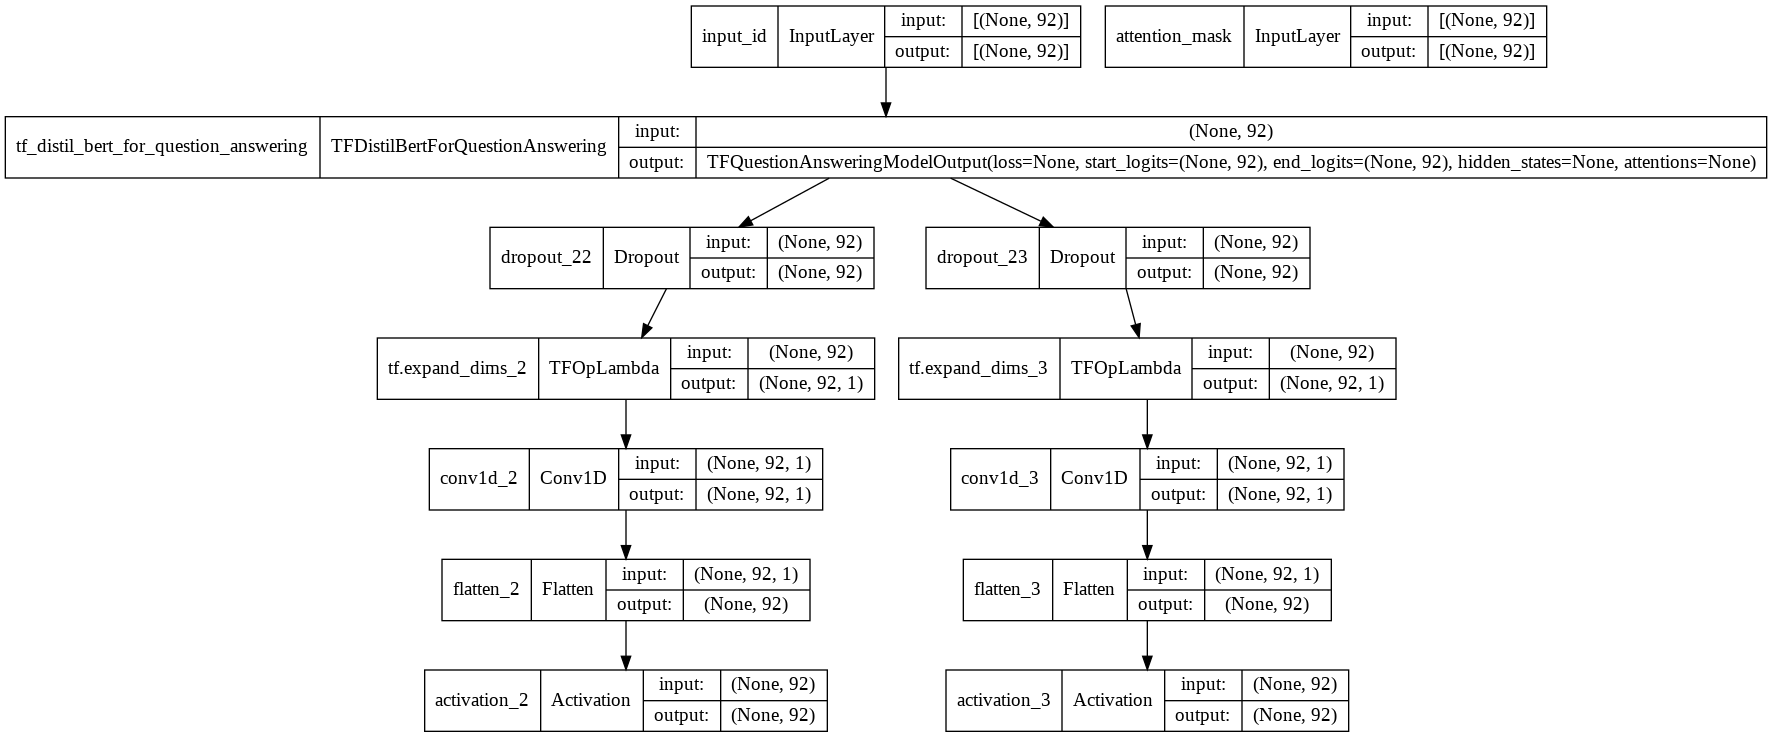

In [ ]:
tf.keras.utils.plot_model(model,'Model.png',show_shapes=True,show_layer_names=True)

In [ ]:
input_data = (input_ids,attention_mask)
output_data = (start_tokens,end_tokens)

val = (input_ids_val,attention_mask_val)
output_val = (start_tokens_val,end_tokens_val)
val_data = (val,output_val)

In [ ]:
# call backs 

estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/DBert_CNN_QA_logdir',histogram_freq=1, write_graph=True)
checkpoint= tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/DBert_CNN_QA_model.hdf5',save_weights_only=True,monitor='val_loss',save_best_only=True)
callbacks=[tensorboard,checkpoint,estop]

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
model.compile(optimizer=opt,loss='categorical_crossentropy')
train_dataset = tf.data.Dataset.from_tensor_slices((input_data, output_data)).shuffle(buffer_size=1024).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(val_data).batch(32)
model.fit(train_dataset,epochs=6,validation_data=val_dataset,callbacks=callbacks)

Epoch 1/6
687/687 [==============================] - 498s 676ms/step - loss: 4.8225 - activation_loss: 2.9820 - activation_1_loss: 1.8405 - val_loss: 3.2080 - val_activation_loss: 1.9704 - val_activation_1_loss: 1.2375
Epoch 2/6
687/687 [==============================] - 464s 676ms/step - loss: 3.1306 - activation_loss: 1.6946 - activation_1_loss: 1.4360 - val_loss: 2.2210 - val_activation_loss: 1.1005 - val_activation_1_loss: 1.1205
Epoch 3/6
687/687 [==============================] - 465s 677ms/step - loss: 2.4754 - activation_loss: 1.2204 - activation_1_loss: 1.2551 - val_loss: 2.1318 - val_activation_loss: 0.9897 - val_activation_1_loss: 1.1420
Epoch 4/6
687/687 [==============================] - 463s 674ms/step - loss: 2.1526 - activation_loss: 1.0490 - activation_1_loss: 1.1036 - val_loss: 2.1249 - val_activation_loss: 0.9806 - val_activation_1_loss: 1.1443
Epoch 5/6
687/687 [==============================] - 460s 669ms/step - loss: 1.8837 - activation_loss: 0.9164 - activation_1

**Prediction**

In [ ]:
val = (input_ids_val,attention_mask_val)
start_val , end_val = model.predict(val)                # validation predictions
start_val.shape,end_val.shape 

((5495, 92), (5495, 92))

In [ ]:
pred_values_val=[]
from tqdm import tqdm
for i in tqdm(range(start_val.shape[0])):
  a = np.argmax(start_val[i])
  b = np.argmax(end_val[i])
  text1 = " "+" ".join(x_val['text'].values[i].split())               # pred_answer
  enc = tokenizer.encode(text1)
  val = tokenizer.decode(enc[a:b+1])
  pred_values_val.append(val)

100%|██████████| 5495/5495 [00:05<00:00, 1027.70it/s]


In [ ]:
for i in range(len(pred_values_val)):
  pred_values_val[i] = pred_values_val[i].replace('[SEP]','')  # removing [sep] token 


In [ ]:
scores_val=[]
x_val['pred_text'] = pred_values_val
x_val['selected_text'] = y_val.values
scores=[]
for i in tqdm(range(x_val.shape[0])):
  scores_val.append(jaccard(x_val['pred_text'].values[i],x_val['selected_text'].values[i]))           # jaccard score calculations

x_val['jaccard']=scores_val  

100%|██████████| 5495/5495 [00:00<00:00, 72385.31it/s]


In [ ]:
x_val.head(20)

,text,sentiment,pred_text,selected_text,jaccard
7917,this is my update,neutral,this is my update,this is my update,1.000000
15845,whaaat i still have next week,neutral,whaaat i still have next week,whaaat i still have next week,1.000000
21278,happy birthday little sister of mine also go...,positive,,happy birthday little sister of mine,0.000000
22338,do some research for my article,neutral,do some research for my article,do some research for my article,1.000000
22474,are you okay,neutral,are you okay,are you okay,1.000000
21560,turned my alarm off this morning because i tho...,negative,,fail,0.000000
8870,elaines my online mommy too she gives good a...,positive,she gives good advice,she gives good advice,1.000000
22030,good ABUSE homie hahahahaha thats what im tal...,positive,good,good,1.000000
6693,there are days of summervac school comes alo...,neutral,there are days of summervac school comes along...,the annual problem of r generation is finding ...,0.590909
15718,i have tea have just found a picture of the b...,neutral,i have tea have just found a picture of the bi...,i have tea have just found a picture of the b...,1.000000


In [ ]:
print('Mean training Jaccard score:',np.mean(x_val['jaccard']))
print("="*150)
print('Mean jaccard score for positive sentiment tweets:',np.mean(x_val[x_val['sentiment']=='positive']['jaccard']))
print("="*150)
print('Mean jaccard score for negative sentiment tweets',np.mean(x_val[x_val['sentiment']=='negative']['jaccard']))
print("="*150)
print('Mean jaccard score for neutral sentiment tweets',np.mean(x_val[x_val['sentiment']=='neutral']['jaccard']))

Mean training Jaccard score: 0.6030671173925883
Mean jaccard score for positive sentiment tweets: 0.35358649825746774
Mean jaccard score for negative sentiment tweets 0.34616903507066615
Mean jaccard score for neutral sentiment tweets 0.9743021383030607


###**BERT+CNN**

In [ ]:
import pickle
train_df = pickle.load(open('/content/drive/MyDrive/Copy of train_df_prep.pkl','rb'))

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val , y_train , y_val = train_test_split(train_df[['text','sentiment']],train_df['selected_text'],test_size=0.2, random_state=42)
x_train.shape, x_val.shape , y_train.shape , y_val.shape

((21976, 2), (5495, 2), (21976,), (5495,))

In [ ]:
from transformers import BertTokenizer,DistilBertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',add_prefix_space=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

**BERT PreP for Train**

In [ ]:
toks_all,input_ids,attention_mask,start_tokens,end_tokens = train_prep(MAX_LEN=92,tokenizer=tokenizer)      # train ids 

21976it [00:41, 527.08it/s]


**BERT PreP for Valid**

In [ ]:
input_ids_val,attention_mask_val,start_tokens_val,end_tokens_val = valid_prep(MAX_LEN=92,tokenizer=tokenizer)             # valid ids 

5495it [00:10, 524.71it/s]


**Model**

In [ ]:
from transformers import TFBertForQuestionAnswering,TFDistilBertForQuestionAnswering
bert= TFBertForQuestionAnswering.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForQuestionAnswering.

Some layers of TFBertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
MAX_LEN = 92
input1 = Input(shape=(MAX_LEN,),name='input_id',dtype=tf.int32)
input2 = Input(shape=(MAX_LEN,),name='attention_mask',dtype=tf.int32)
start_scores,end_scores = bert(input1,attention_mask = input2).values()

drop1 = Dropout(0.1)(start_scores)
drop1  = tf.expand_dims(drop1,axis=-1)
layer1 = tf.keras.layers.Conv1D(1,1)(drop1)                                          # conv1d instead dense
layer1= Flatten()(layer1)
softmax1 = Activation('softmax')(layer1)

drop2 = Dropout(0.1)(end_scores)
drop2  = tf.expand_dims(drop2,axis=-1)
layer2 = tf.keras.layers.Conv1D(1,1)(drop2)                                         # conv1d 
layer2 = Flatten()(layer2)
softmax2 = Activation('softmax')(layer2)

model = Model(inputs=[input1,input2],outputs=[softmax1,softmax2])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_id (InputLayer)          [(None, 92)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 92)]         0           []                               
                                                                                                  
 tf_bert_for_question_answering  TFQuestionAnswering  108893186  ['input_id[0][0]',               
  (TFBertForQuestionAnswering)  ModelOutput(loss=No               'attention_mask[0][0]']         
                                ne, start_logits=(N                                               
                                one, 92),                                                     

In [ ]:
input_data = (input_ids,attention_mask)
output_data = (start_tokens,end_tokens)

val = (input_ids_val,attention_mask_val)
output_val = (start_tokens_val,end_tokens_val)
val_data = (val,output_val)

In [ ]:
# call backs 

estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/Bert_CNN_QA_logdir',histogram_freq=1, write_graph=True)
checkpoint= tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Bert_CNN_QA_model.h5',save_weights_only=True,monitor='val_loss',save_best_only=True)
callbacks=[tensorboard,checkpoint,estop]

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
model.compile(optimizer=opt,loss='categorical_crossentropy')
train_dataset = tf.data.Dataset.from_tensor_slices((input_data, output_data)).shuffle(buffer_size=1024).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(val_data).batch(32)
model.fit(train_dataset,epochs=6,validation_data=val_dataset,callbacks=callbacks)

Epoch 1/6
687/687 [==============================] - 951s 1s/step - loss: 3.1454 - activation_loss: 1.4626 - activation_1_loss: 1.6828 - val_loss: 2.0833 - val_activation_loss: 0.9624 - val_activation_1_loss: 1.1209
Epoch 2/6
687/687 [==============================] - 902s 1s/step - loss: 2.3858 - activation_loss: 1.1510 - activation_1_loss: 1.2347 - val_loss: 1.8716 - val_activation_loss: 0.9020 - val_activation_1_loss: 0.9695
Epoch 3/6
687/687 [==============================] - 894s 1s/step - loss: 2.0379 - activation_loss: 0.9903 - activation_1_loss: 1.0476 - val_loss: 1.9763 - val_activation_loss: 0.9435 - val_activation_1_loss: 1.0329


In [ ]:
model.save("/content/drive/MyDrive/bert_cnn_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
val = (input_ids_val,attention_mask_val)
start_val , end_val = model.predict(val)                # validation predictions
start_val.shape,end_val.shape 

((5495, 92), (5495, 92))

In [ ]:
pred_values_val=[]
from tqdm import tqdm
for i in tqdm(range(start_val.shape[0])):
  a = np.argmax(start_val[i])
  b = np.argmax(end_val[i])
  text1 = " "+" ".join(x_val['text'].values[i].split())               # pred_answer
  enc = tokenizer.encode(text1)
  val = tokenizer.decode(enc[a:b+1])
  pred_values_val.append(val)

100%|██████████| 5495/5495 [00:03<00:00, 1453.32it/s]


In [ ]:
for i in range(len(pred_values_val)):
  pred_values_val[i] = pred_values_val[i].replace('[SEP]','')  # removing [sep] token 

In [ ]:
scores_val=[]
x_val['pred_text'] = pred_values_val
x_val['selected_text'] = y_val.values
scores=[]
for i in tqdm(range(x_val.shape[0])):
  scores_val.append(jaccard(x_val['pred_text'].values[i],x_val['selected_text'].values[i]))           # jaccard score calculations

x_val['jaccard']=scores_val  

100%|██████████| 5495/5495 [00:00<00:00, 79204.17it/s]


In [ ]:
x_val.head(20)

,text,sentiment,pred_text,selected_text,jaccard
7917,this is my update,neutral,this is my update,this is my update,1.000000
15845,whaaat i still have next week,neutral,whaaat i still have next week,whaaat i still have next week,1.000000
21278,happy birthday little sister of mine also go...,positive,happy birthday,happy birthday little sister of mine,0.333333
22338,do some research for my article,neutral,do some research for my article,do some research for my article,1.000000
22474,are you okay,neutral,are you okay,are you okay,1.000000
21560,turned my alarm off this morning because i tho...,negative,,fail,0.000000
8870,elaines my online mommy too she gives good a...,positive,advice,she gives good advice,0.250000
22030,good ABUSE homie hahahahaha thats what im tal...,positive,good,good,1.000000
6693,there are days of summervac school comes alo...,neutral,there are days of summervac school comes along...,the annual problem of r generation is finding ...,0.590909
15718,i have tea have just found a picture of the b...,neutral,i have tea have just found a picture of the bi...,i have tea have just found a picture of the b...,1.000000


In [ ]:
print('Mean training Jaccard score:',np.mean(x_val['jaccard']))
print("="*150)
print('Mean jaccard score for positive sentiment tweets:',np.mean(x_val[x_val['sentiment']=='positive']['jaccard']))
print("="*150)
print('Mean jaccard score for negative sentiment tweets',np.mean(x_val[x_val['sentiment']=='negative']['jaccard']))
print("="*150)
print('Mean jaccard score for neutral sentiment tweets',np.mean(x_val[x_val['sentiment']=='neutral']['jaccard']))

Mean training Jaccard score: 0.6003635046014968
Mean jaccard score for positive sentiment tweets: 0.35372741948989095
Mean jaccard score for negative sentiment tweets 0.34164678987434965
Mean jaccard score for neutral sentiment tweets 0.9706531575031069
